In [51]:
import numpy as np
import os
import sys
import time
import logging
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_dir, 'src')

# Add the src directory to sys.path
sys.path.append(src_dir)

import mech.GaussianDist as GaussianModule
import mech.LapDist as LaplaceModule
import mech.toy_DPSGD as DP_SGDModule
import mech.Subsampling as SubsamplingModule

In [52]:
from scipy.stats import norm
# Define Gaussian curve function
mu_1 = 0
mu_2 = 0.2
def Gaussian_curve(alpha):
    return norm.cdf(norm.ppf(1 - alpha) - mu_2)

In [79]:
# Load the CSV file
data = pd.read_csv("~/Documents/R/f-DP/results/results_Gaussian/results_N10000/Tradeoff_Gaussian_KDE_N10000_h0.1_eta15_iter1.csv")

# Step 1: Filter the data to only include rows where 0 <= alpha <= 1
filtered_data = data[(data['alpha'] >= 0) & (data['alpha'] <= 1)]
#filtered_data = filtered_data.drop_duplicates(subset=['alpha'], keep='first')

# Step 2: Extract alpha and beta values
alpha_values = filtered_data['alpha'].values
beta_values = filtered_data['beta'].values

deviation_matrix = np.array(beta_values - Gaussian_curve(alpha_values))
#trimmed_matrix = deviation_matrix[1:-1]  # Exclude the first and last elements
min_value = np.argmin(deviation_matrix)
datapoint= data[data['beta'] == beta_values[min_value]]


the_alpha=datapoint["alpha"]
the_beta=datapoint["beta"]
print(Gaussian_curve(the_alpha))
print(the_beta)
print(np.where(data['beta']==beta_values[min_value]))
index=np.where(data['beta']==beta_values[min_value])
eta_value=np.linspace(0,15,1000)[index]

[0.67194499]
60    0.353802
Name: beta, dtype: float64
(array([60]),)


In [81]:
test_train_sample_size = 10**6
test_test_sample_size = 10**6
def compute_expression(n, gamma):
    c_d = 3.8637  # Given value of c_d
    result = 12 * np.sqrt((2 * c_d ** 2 / n) * np.log(4 / gamma))
    return result
eta=np.array([eta_value])

kwargs = GaussianModule.generate_params(num_train_samples = test_train_sample_size, num_test_samples = test_test_sample_size)
estimator = GaussianModule.GaussianDistEstimator(kwargs)
output = estimator.build(eta = eta)
beta_estimate_6  = output["beta"]
alpha_estimate_6 = output["alpha"]

In [85]:
gamma=0.05

omega=compute_expression(10**6, 0.001)
omega_6=compute_expression(10**6,0.01)
omega_7=compute_expression(10**6, 0.1)
print(omega)

0.1888352019025362


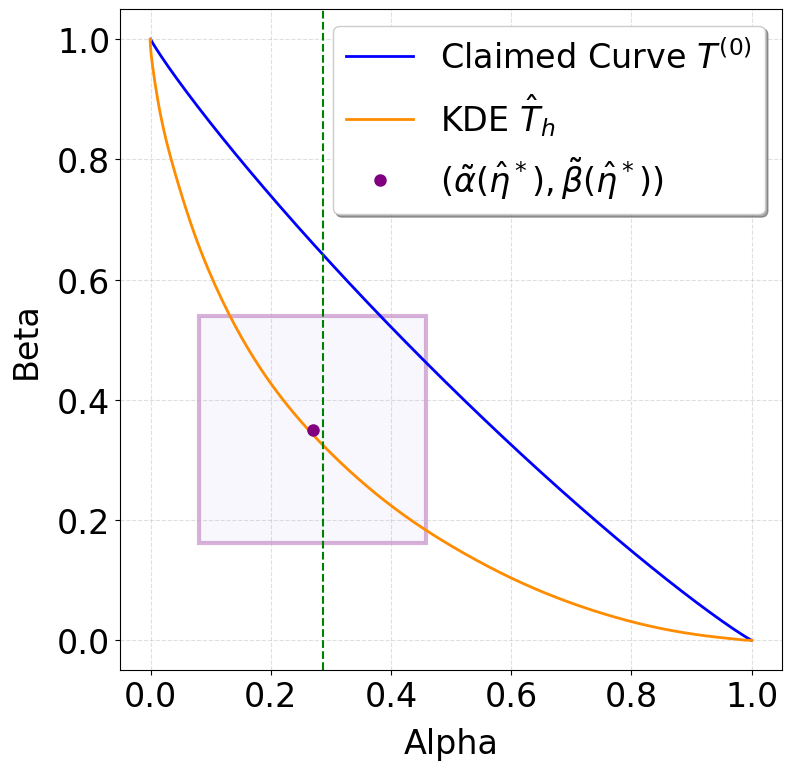

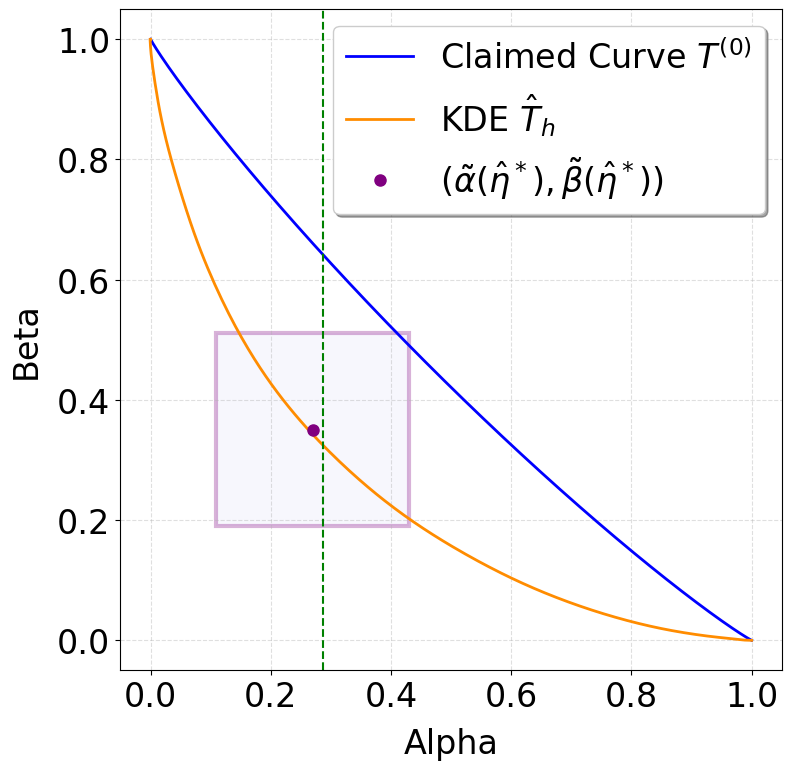

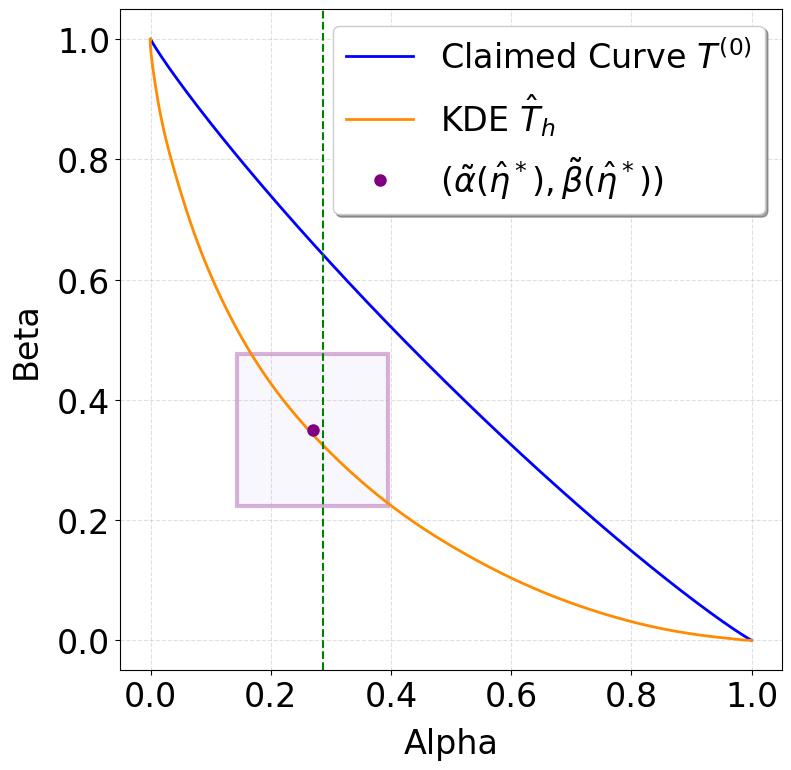

In [86]:
import matplotlib.pyplot as plt
from matplotlib import patches

import numpy as np


def create_plot(omega, alpha_estimate, beta_estimate, fine_points, alpha, beta, the_alpha, the_beta, filename="plot.png"):
    """
    Create a plot with a Gaussian curve, KDE scatter, and a highlighted critical region.

    Parameters:
    - omega: Width/height of the shaded square (float).
    - alpha_estimate: The x-coordinate of the critical region center (float).
    - beta_estimate: The y-coordinate of the critical region center (float).
    - fine_points: Array of x-values for the Gaussian curve (array-like).
    - Gaussian_curve: Function to compute the Gaussian curve (function).
    - alpha: Array of x-coordinates for KDE scatter points (array-like).
    - beta: Array of y-coordinates for KDE scatter points (array-like).
    - the_alpha: The x-coordinate of the critical point (float).
    - the_beta: The y-coordinate of the second critical point (float).
    - filename: Name of the file to save the plot (str).
    """
    plt.figure(figsize=(8, 8))  # Adjust size for better presentation

    points = np.array([Gaussian_curve(point) for point in fine_points])

    plt.plot(fine_points, points, color='blue', label=r'Claimed Curve $T^{(0)}$', linewidth=2)

    alpha = np.concatenate(([0], alpha, [1]))
    beta = np.concatenate(([1], beta, [0]))

    # Plot the curve
    plt.plot(alpha, beta, color="darkorange", label="KDE $\hat{T}_h$", linewidth=2)
    
    # Add a shaded rectangle around the critical region
    rectangle = patches.Rectangle(
        (alpha_estimate - omega, beta_estimate - omega),  # Bottom-left corner
        2 * omega,                     # Width
        2 * omega,                     # Height
        linewidth=3,                          # Line width
        edgecolor='purple',                   # Edge color
        facecolor='lavender',                 # Fill color
        alpha=0.3                             # Transparency of the fill
    )
    plt.gca().add_patch(rectangle)

    # Add a dummy plot for the legend
    #plt.plot([], [], color='purple', label="Confidence Region")

    # Keep aspect ratio equal
    plt.gca().set_aspect('equal', adjustable='box')

    # Mark the critical points
    plt.plot(alpha_estimate, beta_estimate, 'o', markersize=8, color='purple',
             label=r'$(\tilde{\alpha}(\hat{\eta}^*), \tilde{\beta}(\hat{\eta}^*))$')  # Critical point 1
    #plt.plot(the_alpha, the_beta, 's', markersize=8, color='green',
    #         label=r'$(\hat{\alpha}(\hat{\eta}^*), \hat{\beta}(\hat{\eta}^*))$')  # Critical point 2
    plt.axvline(x=the_alpha, color='green', linestyle='--', linewidth=1.5)
    # Adjust labels, title, and legend for better readability
    plt.xlabel('Alpha', fontsize=24, labelpad=10)
    plt.ylabel('Beta', fontsize=24, labelpad=10)
    plt.legend(fontsize=24, loc='upper right', frameon=True, shadow=True)

    # Improve ticks and grid
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(alpha=0.4, linestyle='--')

    # Tight layout for better spacing
    plt.tight_layout()

    # Save the figure with higher resolution
    plt.savefig(filename, dpi=300)

    # Display the plot
    plt.show()
# Call the function
create_plot(omega, alpha_estimate_6,beta_estimate_6, np.linspace(0,1,500), data["alpha"], data["beta"], alpha_values[index], beta_values[index], "gauss_faulty_gamma_0.001_mu_0.2.png")
create_plot(omega_6, alpha_estimate_6,beta_estimate_6, np.linspace(0,1,500), data["alpha"], data["beta"], alpha_values[index], beta_values[index], "gauss_faulty_gamma_0.01_mu_0.2.png")
create_plot(omega_7, alpha_estimate_6,beta_estimate_6, np.linspace(0,1,500), data["alpha"], data["beta"], alpha_values[index], beta_values[index], "gauss_faulty_gamma_0.1_mu_0.2.png")

